### Just took the pytorch tutorial on transfer learning and used it on the Flowers data set
Slightly altered it to make it work for my data :-)

tutorial: <br>
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html <br>
flowers dataset: <br>
http://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html

In [3]:
%matplotlib inline


Transfer Learning Tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [4]:
# License: BSD
# Author: Sasank Chilamkurthy
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify flowers instead of the 
**ants** and **bees**. 

From the [visual geometry group](http://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html) the flower images are downloaded and put in the following folder structure. train folder with subfolders per species, and val folder with subfolders per species. There are 60 train images and 20 validation images per species.

In [2]:
!tree flowers

flowers
├── train
│   ├── bluebell
│   │   ├── image_0241.jpg
│   │   ├── image_0242.jpg
│   │   ├── image_0243.jpg
│   │   ├── image_0244.jpg
│   │   ├── image_0245.jpg
│   │   ├── image_0246.jpg
│   │   ├── image_0247.jpg
│   │   ├── image_0248.jpg
│   │   ├── image_0249.jpg
│   │   ├── image_0250.jpg
│   │   ├── image_0251.jpg
│   │   ├── image_0252.jpg
│   │   ├── image_0253.jpg
│   │   ├── image_0254.jpg
│   │   ├── image_0255.jpg
│   │   ├── image_0256.jpg
│   │   ├── image_0257.jpg
│   │   ├── image_0258.jpg
│   │   ├── image_0259.jpg
│   │   ├── image_0260.jpg
│   │   ├── image_0261.jpg
│   │   ├── image_0262.jpg
│   │   ├── image_0263.jpg
│   │   ├── image_0264.jpg
│   │   ├── image_0265.jpg
│   │   ├── image_0266.jpg
│   │   ├── image_0267.jpg
│   │   ├── image_0268.jpg
│   │   ├── image_0269.jpg
│   │   ├── image_0270.jpg
│   │   ├── image_0271.jpg
│   │   ├── image_0272.jpg
│   │   ├── image_0273.jpg
│   │   ├── image_0274.jpg
│   │   ├── image_0275.jpg
│   │   ├── image_02

### set data directory with images

In [7]:
data_dir = 'flowers'

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 6,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
print("dataset sizes")
print(dataset_sizes)
print("class names")
print(class_names)

dataset sizes
{'train': 300, 'val': 100}
class names
['bluebell', 'crocus', 'daffodil', 'lilyvally', 'snowdrop']


## Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations.



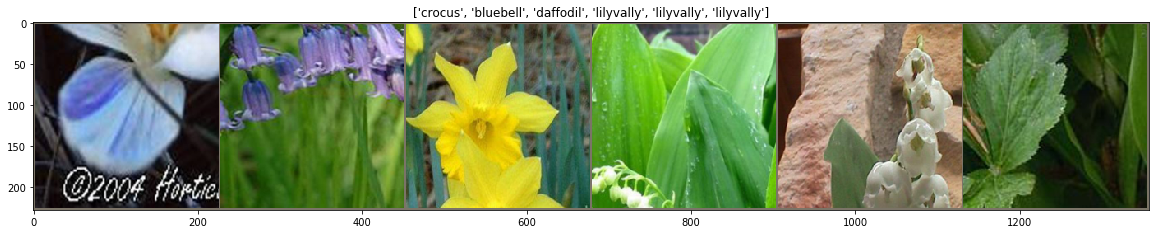

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(figsize=(20,10))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase == 'train':
                train_acc[epoch] = epoch_acc 
            else:
                val_acc[epoch] = epoch_acc

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions
Generic function to display predictions for a few images




In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [14]:
numclass = len(class_names)
numclass

5

In [15]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, numclass)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train the model

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [16]:
numepochs = 15
train_acc = np.zeros(numepochs)
val_acc = np.zeros(numepochs)

model_ft = train_model(
    model_ft, 
    criterion, 
    optimizer_ft, 
    exp_lr_scheduler,
    num_epochs = numepochs
)

Epoch 0/14
----------
train Loss: 1.1576 Acc: 0.5400
val Loss: 0.4356 Acc: 0.8400

Epoch 1/14
----------
train Loss: 0.4692 Acc: 0.8567
val Loss: 0.2487 Acc: 0.9200

Epoch 2/14
----------
train Loss: 0.4088 Acc: 0.8767
val Loss: 0.1862 Acc: 0.9300

Epoch 3/14
----------
train Loss: 0.2852 Acc: 0.9033
val Loss: 0.1813 Acc: 0.9300

Epoch 4/14
----------
train Loss: 0.2785 Acc: 0.9000
val Loss: 0.1252 Acc: 0.9400

Epoch 5/14
----------
train Loss: 0.2051 Acc: 0.9200
val Loss: 0.1004 Acc: 0.9800

Epoch 6/14
----------
train Loss: 0.2100 Acc: 0.9200
val Loss: 0.0849 Acc: 0.9800

Epoch 7/14
----------
train Loss: 0.2053 Acc: 0.9233
val Loss: 0.0937 Acc: 0.9600

Epoch 8/14
----------
train Loss: 0.1631 Acc: 0.9400
val Loss: 0.0911 Acc: 0.9600

Epoch 9/14
----------
train Loss: 0.1636 Acc: 0.9533
val Loss: 0.1072 Acc: 0.9600

Epoch 10/14
----------
train Loss: 0.2068 Acc: 0.9367
val Loss: 0.0723 Acc: 0.9900

Epoch 11/14
----------
train Loss: 0.1467 Acc: 0.9500
val Loss: 0.1028 Acc: 0.9600

Ep

### save the model

In [17]:
torch.save(model_ft, "data/flowermodel.pt")

### evalutate the model

In [19]:
# Model class must be defined somewhere
flowermodel  = torch.load("data/flowermodel.pt")
flowermodel.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

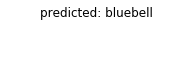

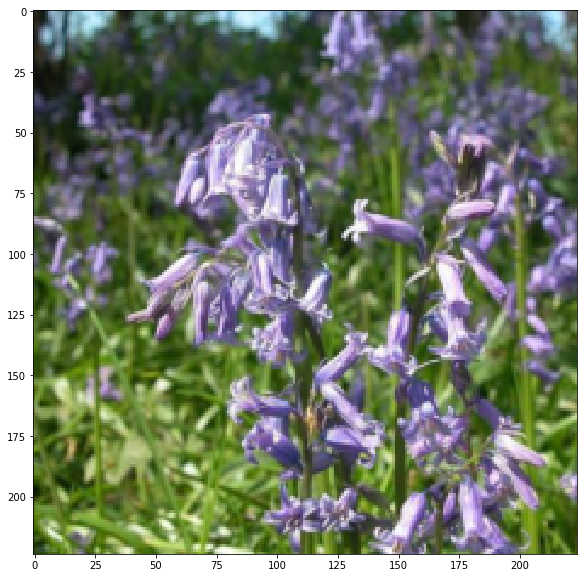

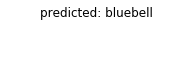

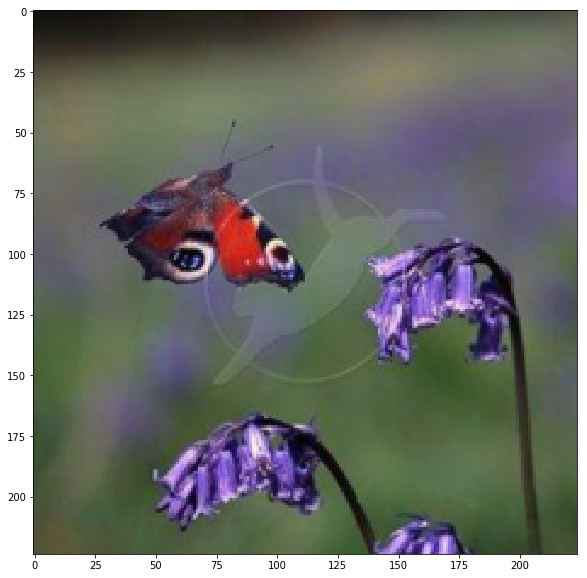

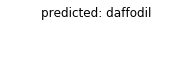

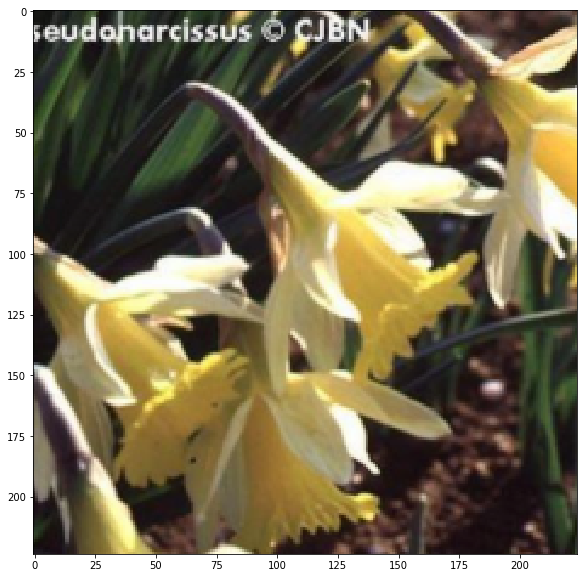

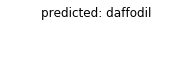

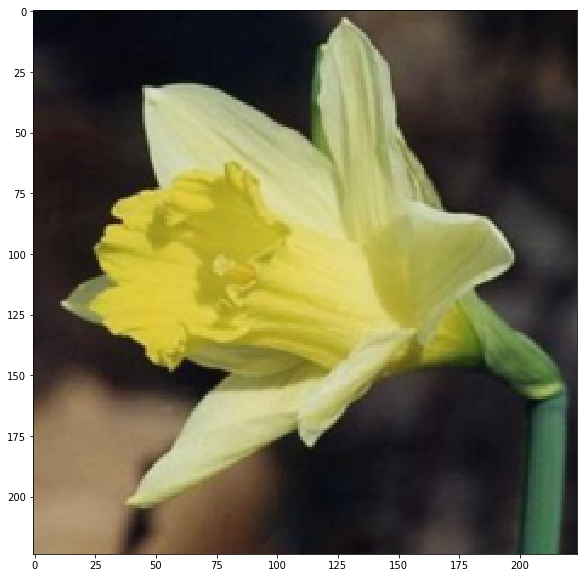

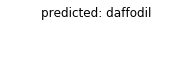

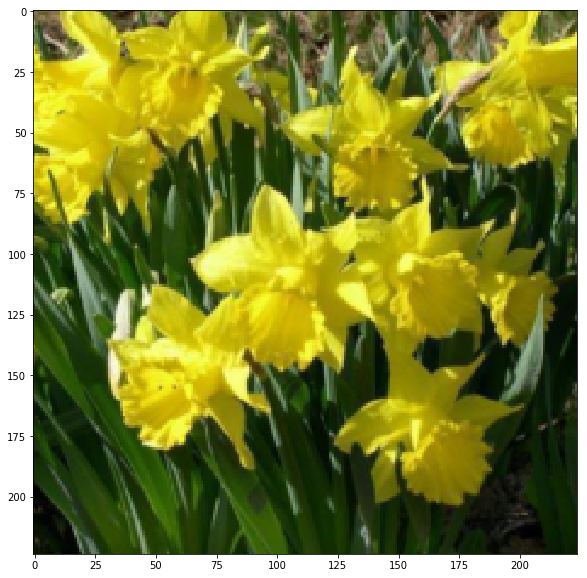

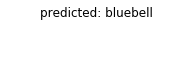

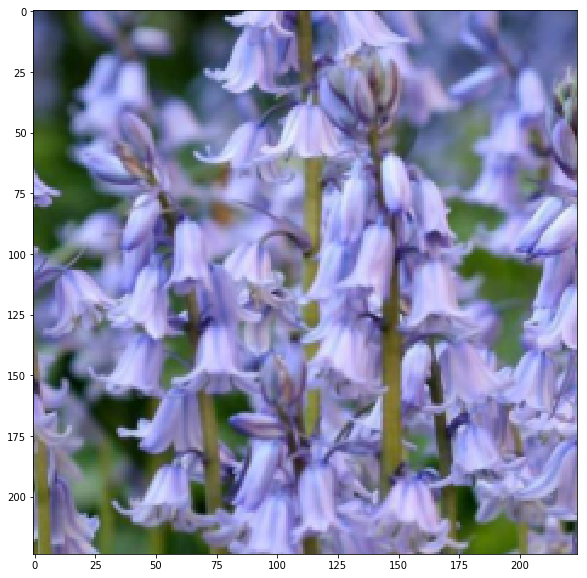

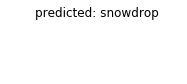

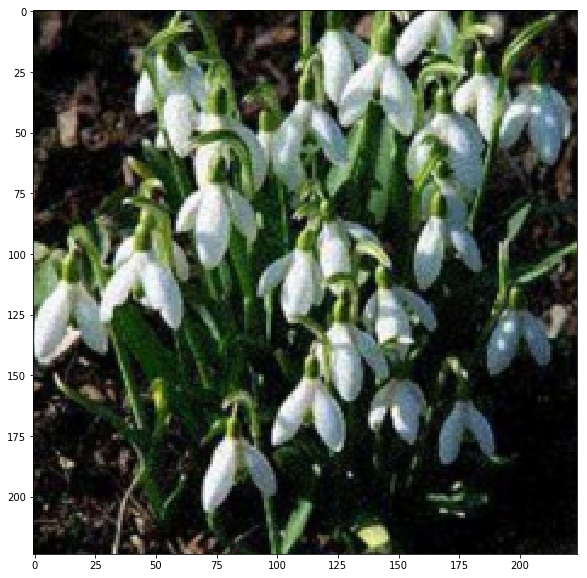

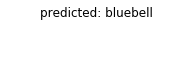

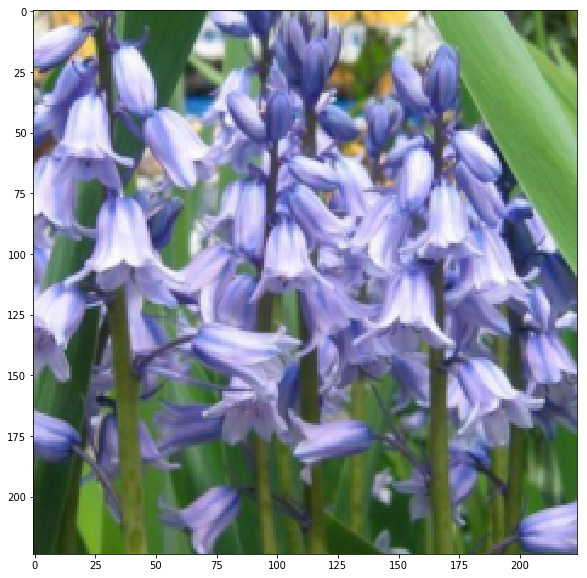

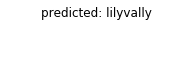

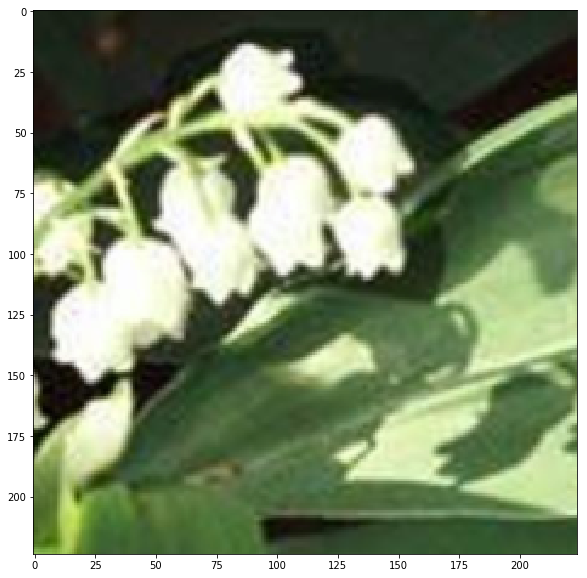

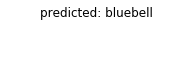

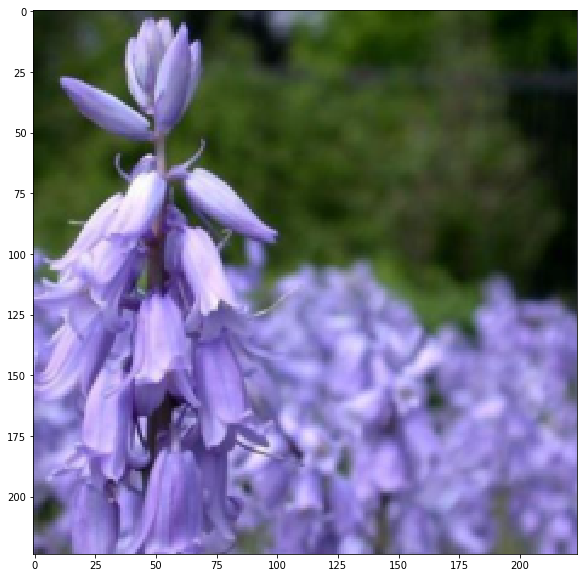

In [12]:
visualize_model(flowermodel, num_images=10)

In [21]:
correct = 0
total = 0

with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = flowermodel(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 99 %


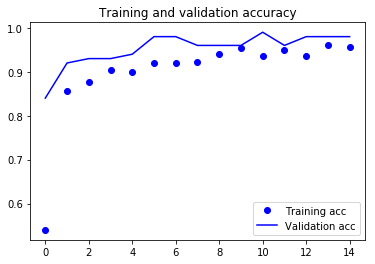

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(len(val_acc))

plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

### score on new image

I used only 4 species now

In [27]:
import io

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable

IMG = Image.open("www/87784A_1.jpg")

preprocess = transforms.Compose([
    transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

inputs = preprocess(IMG)
inputs.unsqueeze_(0)
outputs = flowermodel(inputs)
_, predicted = torch.max(outputs, 1)

print(class_names)
print(predicted)

['bluebell', 'crocus', 'daffodil', 'lilyvally', 'snowdrop']
tensor([2])


In [25]:
sm = torch.nn.Softmax()
probabilities = sm(outputs) 
probabilities.detach().numpy()

/home/longhowlam/anaconda3/envs/my_py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


array([[6.8742585e-05, 6.1974351e-05, 9.9982113e-01, 4.3217031e-05,
        4.8824763e-06]], dtype=float32)

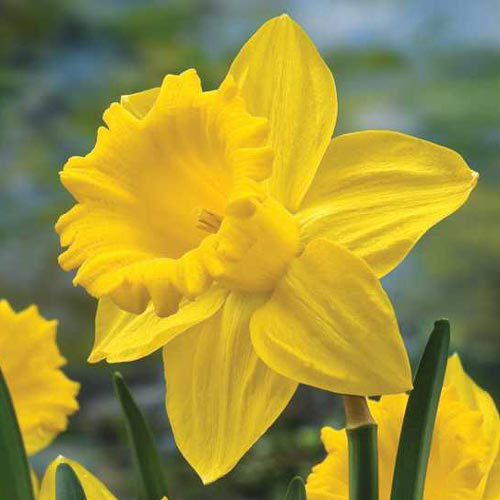

In [26]:
IMG